Preliminary code

In [621]:
# Import libraries
import numpy as np
import marvin
from marvin import config
import pandas as pd
from marvin.tools import Maps, Cube
from marvin.tools.vacs import VACs
from marvin.tools.image import Image
from astropy.io import fits, ascii, misc
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import Planck18, z_at_value
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import random
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.ndimage.filters import gaussian_filter

# Define functions
def lookupNearest(x0, y0, data):
    """
    Returns index of nearest neighbour of a 2D array to a set of data points
    """
    
    # Find distance in parameter space to each set of points
    xi = np.abs(data[:, 0]-x0)
    yi = np.abs(data[:, 1]-y0)
    ri = np.sqrt(xi**2 + yi**2)
    
    # Locate index of nearest data point
    id_nearest = ri.argmin()
    
    return id_nearest

### Load in Astropy Tables

Comerford's AGN catalogue

In [2]:
comerford_agn_tb = Table.read('/Users/Jonah/SMBH_Growth/AGN_Stuff/manga_agn-v2_0_1.fits')
comerford_agn_tb

MANGAID,RA,DEC,Z,WISE_AGN,LOG_LBOL_WISE,LOG_LBOL_WISE_ERR,BAT_AGN,LOG_LBOL_BAT,LOG_LBOL_BAT_ERR,RADIO_AGN,LOG_LBOL_RADIO,LOG_LBOL_RADIO_ERR,RADIO_CLASS,BROAD_AGN,LOG_LBOL_BROAD,LOG_LBOL_BROAD_ERR
bytes17,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float32,bytes4,int16,float32,float32
manga-10214-3703,122.92139,36.115776,0.0862614,0,-99.0,-99.0,0,-99.0,-99.0,1,45.51227,46.662697,LERG,0,-99.0,-99.0
manga-10216-9101,116.672745,18.73484,0.0514557,0,-99.0,-99.0,0,-99.0,-99.0,1,44.712452,45.85495,LERG,0,-99.0,-99.0
manga-10222-12701,43.097507,-8.51039,0.0167549,1,44.12801,43.18389,1,44.127884,-99.0,0,43.43977,44.569344,na,0,-99.0,-99.0
manga-10222-6103,42.984875,-8.377049,0.061948,0,-99.0,-99.0,0,-99.0,-99.0,0,-99.0,-99.0,na,1,44.777576,45.897804
manga-10223-3701,31.566603,-0.2914371,0.0429575,1,44.8786,43.934483,1,44.927883,-99.0,0,-99.0,-99.0,na,1,45.36174,46.487267
manga-10223-3702,33.524643,-0.27696112,0.0373341,1,43.680645,42.76811,0,-99.0,-99.0,0,-99.0,-99.0,na,0,-99.0,-99.0
manga-10226-6104,38.255203,0.420819,0.0223465,1,44.40734,43.463223,0,-99.0,-99.0,0,43.646774,44.77848,na,0,-99.0,-99.0
manga-10492-6103,122.972984,57.951893,0.0277501,1,44.326668,43.38754,0,-99.0,-99.0,0,44.01383,45.14928,na,0,-99.0,-99.0
manga-10493-1902,124.32737,52.029915,0.0385406,1,43.73928,42.826744,0,-99.0,-99.0,0,-99.0,-99.0,na,1,44.839363,45.96015


Comerford's AGN catalogue filtered for only obscured AGN

In [383]:
obscured_agn_tb = Table.read('/Users/Jonah/SMBH_Growth/AGN_Stuff/obscured_agn.fits')
obscured_agn_tb

MANGAID,RA,DEC,Z,WISE_AGN,LOG_LBOL_WISE,LOG_LBOL_WISE_ERR,BAT_AGN,LOG_LBOL_BAT,LOG_LBOL_BAT_ERR,RADIO_AGN,LOG_LBOL_RADIO,LOG_LBOL_RADIO_ERR,RADIO_CLASS,BROAD_AGN,LOG_LBOL_BROAD,LOG_LBOL_BROAD_ERR
bytes17,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float32,bytes4,int16,float32,float32
manga-10214-3703,122.92139,36.115776,0.0862614,0,-99.0,-99.0,0,-99.0,-99.0,1,45.51227,46.662697,LERG,0,-99.0,-99.0
manga-10216-9101,116.672745,18.73484,0.0514557,0,-99.0,-99.0,0,-99.0,-99.0,1,44.712452,45.85495,LERG,0,-99.0,-99.0
manga-10226-6104,38.255203,0.420819,0.0223465,1,44.40734,43.463223,0,-99.0,-99.0,0,43.646774,44.77848,na,0,-99.0,-99.0
manga-10492-6103,122.972984,57.951893,0.0277501,1,44.326668,43.38754,0,-99.0,-99.0,0,44.01383,45.14928,na,0,-99.0,-99.0
manga-10493-6103,123.431725,52.960617,0.138128,0,-99.0,-99.0,0,-99.0,-99.0,1,46.524612,47.68487,LERG,0,-99.0,-99.0
manga-10494-12702,124.51605,54.619083,0.117425,0,-99.0,-99.0,0,-99.0,-99.0,1,46.76829,47.930885,LERG,0,-99.0,-99.0
manga-10494-12704,125.38826,55.15197,0.0797181,0,-99.0,-99.0,0,-99.0,-99.0,1,44.609985,45.751457,LERG,0,-99.0,-99.0
manga-10494-6102,124.924095,54.627277,0.0805874,0,-99.0,-99.0,0,-99.0,-99.0,1,44.67475,45.81687,LERG,0,-99.0,-99.0
manga-10496-6104,126.502396,40.981113,0.0575645,0,-99.0,-99.0,0,-99.0,-99.0,1,44.676266,45.8184,LERG,0,-99.0,-99.0


DVSG values for selected AGN sample

In [356]:
# Open pickle file using pandas
dvsg_agn_data = pd.read_pickle('dvsg_agn_data.pkl')

# Convert list to array
dvsg_agn_arr = np.asarray(dvsg_agn_data)

# Loop over data and reshape elements
for i in range(len(dvsg_agn_data)):
    # Get original map size
    size = dvsg_agn_arr[i]['map_size']

    # Reshape each velocity map
    dvsg_agn_arr[i]['stellar_vel'] = dvsg_agn_arr[i]['stellar_vel'].reshape((size, size))
    dvsg_agn_arr[i]['gas_vel'] = dvsg_agn_arr[i]['gas_vel'].reshape((size, size))
    dvsg_agn_arr[i]['dvsg'] = dvsg_agn_arr[i]['dvsg'].reshape((size, size))

# Read array into astropy Table
dvsg_agn_tb = Table(list(dvsg_agn_arr))
dvsg_agn_tb

plateifu,map_size,stellar_vel,gas_vel,dvsg,dvsg_sum_norm,nsa_z,nsa_elpetro_mass
str11,int64,object,object,object,float64,float64,float64
10214-3703,44,[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],0.34184587149784484,0.0862614,102170000000.0
10216-9101,64,[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],0.3518645542879489,0.0514557,115634000000.0
10226-6104,52,[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],0.21345257437673473,0.0223465,17237000000.0
10492-6103,54,[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],0.4234158607007202,0.0277501,10842200000.0
10493-6103,54,[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],0.5362394587657943,0.138128,187976000000.0
10494-12702,74,[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]],[[nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n ...\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan nan]\n [nan nan nan ... nan nan n

GalaxyZoo2 Classifications

In [389]:
gz2_tb = Table.read('/Users/Jonah/Downloads/MaNGA_gz-v2_0_1.fits')
gz2_tb

PLATEIFU,MANGAID,OBJRA,OBJDEC,Z,MNGTARG1,MNGTARG2,MNGTARG3,IFUDESIGNSIZE,crossmatch_separation,dr7objid,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t06_odd_a14_yes_weighted_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_flag,t06_odd_a15_no_count,t06_odd_a15_no_weight,t06_odd_a15_no_fraction,t06_odd_a15_no_weighted_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_flag,t07_rounded_a16_completely_round_count,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_fraction,t07_rounded_a16_completely_round_weighted_fraction,t07_rounded_a16_completely_round_debiased,t07_rounded_a16_completely_round_flag,t07_rounded_a17_in_between_count,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_fraction,t07_rounded_a17_in_between_weighted_fraction,t07_rounded_a17_in_between_debiased,t07_rounded_a17_in_between_flag,t07_rounded_a18_cigar_shaped_count,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cig

DRPall table (with AGN, nan logged masses & drp3qual flags removed)

In [411]:
drpall_tb = Table.read('/Users/Jonah/sas/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits')

# Remove AGN from DRPall
agn_plateifu_arr = np.asarray([sub[6:].strip() for sub in comerford_agn_tb['MANGAID']])
agn_bool_arr = np.isin(drpall_tb['plateifu'].data, agn_plateifu_arr)  # Create boolean array of agn
agn_ids = np.nonzero(agn_bool_arr)[0]  # Get the indices of Comerford agn matches
drpall_tb.remove_rows(agn_ids)  # Remove agn rows from drpall

# Remove any galaxies with drp3qual not equal to 0
drpall_tb = drpall_tb[drpall_tb['drp3qual'] == 0]

# Remove any galaxies where taking np.log10 of mass gives nan
drpall_tb = drpall_tb[np.isfinite(np.log10(drpall_tb['nsa_elpetro_mass'].data))]

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7]
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08789,1.19925,-999.0,0.66562,0.705713,203,1350,6,v1_0_1,51226,-999,0.0392074,0.0395926,-16.2982 .. -19.5112,-16.2321 .. -19.5522,275.541 .. 452.944,3068010000.0,2685340000.0,0.417013,69.2463,0.448783 .. 0.0800664,5.16633,3.63987,12.7947 .. 413.049,3.26768 .. 0.000422625,13.8306 .. 425.941,3.03694 .. 0.00496838,0.335333,0.741845,68.2584,5.29184,14.8124 .. 412.19,2.50888 .. 0.0150605
10001,12702,10001-12702,1-48188,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.685669869,57.4802503218,159.390126911,39.0253440844,133.68567,57.48025,0.0492053,9,8100.81,0,20.0835,41.292,ma078,25,3,9114,134.41357,57.604214,1.10569,1.15089,1.21106,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.72072,2.66314,2.64652,2.61686,2080,0,0,1,plateTargets-1.par,6013,J085444.56+572848.8,127,217,0,0.0408108,0.0193227,0.0264533,0.0386469,0.042869,0.0188554,0.0266531,0.794785,-999.0,0.651037,0.681893,1.04947,1.13205,-999.0,0.631507,0.660498,35,3600,5,v1_0_1,51261,-999,0.0408108,0.0411932,-15.9069 .. -19.6569,-16.127 .. -19.5493,206.664 .. 49.3569,5341650000.0,4642460000.0,0.598115,12.5169,0.405779 .. 0.072394,7.01311,6.11281,12.4553 .. 396.399,2.27628 .. 0.000372112,12.4406 .. 390.985,2.3517 .. 0.000398299,0.508217,1.44272,12.3759,8.34906,10.1128 .. 432.884,3.38905 .. 0.00964978
10001,12703,10001-12703,1-55648,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,136.017159969,57.0923291779,159.56459216,40.3368076472,136.01716,57.092329,0.0258626,9,8100.81,0,19.9086,40.7596,ma077,31,3,9114,134.41357,57.604214,1.09975,1.13824,1.19323,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.7262,2.61384,2.56576,2.53132,2080,0,0,1,plateT

### METHOD 1: Construct control sample (mass-matched and red-shift-matched) by filtering from DRPall

Proof of concept for first galaxy

In [358]:
# Look for redshift matches
z = dvsg_agn_tb['nsa_z'][0]
z_match = np.where(np.abs(z - drpall_tb['z']) <= 0.04)[0]

# Look for mass matches
mass = dvsg_agn_tb['nsa_elpetro_mass'][0]
mass_match = np.where(np.abs(np.log10(mass / drpall_tb['nsa_elpetro_mass'])) < 0.1)[0]

# Look for intersection of z and mass matches
z_mass_match = [ind for ind in z_match if ind in mass_match]
z_mass_match
print("matched size:", len(z_mass_match))

# Pick random value from matched list
ind = random.choice(z_mass_match)

# Check that it is a good control value
print("\nAGN z:", z)
print("control z:", drpall_tb['z'][ind])

print("\nAGN mass (log):", np.log10(mass))
print("control mass (log):", np.log10(drpall_tb['nsa_elpetro_mass'][ind]))

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


matched size: 356

AGN z: 0.0862614
control z: 0.11615

AGN mass (log): 11.009323393381013
control mass (log): 10.961020789145477


Repeat for all AGN

In [359]:
control_data_list = []

# Check DRPall is right size
print("DRPall size (should be 6950):", len(drpall_tb))

for i in range(len(dvsg_agn_tb)):
    print("\ni:", i)
    
    # Look for redshift matches
    z = dvsg_agn_tb['nsa_z'][i]
    z_match = np.where(np.abs(z - drpall_tb['z']) <= 0.0425)[0]
    print("n_control_z:", len(z_match))

    # Look for mass matches
    mass = dvsg_agn_tb['nsa_elpetro_mass'][i]
    mass_match = np.where(np.abs(np.log10(mass / drpall_tb['nsa_elpetro_mass'])) <= 0.1)[0]
    print("n_control_mass:", len(mass_match))

    # Look for intersection of z and mass matches
    z_mass_match = [ind for ind in z_match if ind in mass_match]
    z_mass_match

    # Pick random value from matched list
    ind = random.choice(z_mass_match)
    
    # Create dictionary of values for control sample
    control_data = {
        'plateifu': drpall_tb['plateifu'][ind],
        'z': drpall_tb['z'][ind],
        'nsa_elpetro_mass': drpall_tb['nsa_elpetro_mass'][ind],
        'DRPall_index': ind
    }
    
    # Append to control sample list
    control_data_list.append(control_data)
    
    # Remove control_ind from drpall_tb
    drpall_tb.remove_row(ind)

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


DRPall size (should be 6950): 6950

i: 0
n_control_z: 2394
n_control_mass: 489

i: 1
n_control_z: 6381
n_control_mass: 418

i: 2
n_control_z: 5657
n_control_mass: 715

i: 3
n_control_z: 5859
n_control_mass: 672

i: 4
n_control_z: 470
n_control_mass: 121

i: 5
n_control_z: 860
n_control_mass: 4

i: 6
n_control_z: 3146
n_control_mass: 352

i: 7
n_control_z: 3033
n_control_mass: 485

i: 8
n_control_z: 6379
n_control_mass: 97

i: 9
n_control_z: 1358
n_control_mass: 426

i: 10
n_control_z: 1754
n_control_mass: 567

i: 11
n_control_z: 6337
n_control_mass: 705

i: 12
n_control_z: 443
n_control_mass: 404

i: 13
n_control_z: 2469
n_control_mass: 356

i: 14
n_control_z: 4465
n_control_mass: 341

i: 15
n_control_z: 5969
n_control_mass: 410

i: 16
n_control_z: 718
n_control_mass: 491

i: 17
n_control_z: 6401
n_control_mass: 545

i: 18
n_control_z: 6198
n_control_mass: 705

i: 19
n_control_z: 4742
n_control_mass: 579

i: 20
n_control_z: 4280
n_control_mass: 666

i: 21
n_control_z: 5731
n_control_ma

In [361]:
# Convert the Table to a FITS HDU
hdu = fits.BinTableHDU(control_tb)

# Write the HDU to a FITS file
hdu.writeto('control_sample.fits', overwrite=True)

Compare similarity of distributions visually and statistically

In [370]:
# Compute KS values for each distribution
ks_z = ks_2samp(obscured_agn_tb['Z'].data, control_tb['z'].data)
ks_mass = ks_2samp(np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), np.log10(control_tb['nsa_elpetro_mass'].data))

# Compute AD values for each distribution
res_z = anderson_ksamp((obscured_agn_tb['Z'].data, control_tb['z'].data))
res_mass = anderson_ksamp((np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), np.log10(control_tb['nsa_elpetro_mass'].data)))

[WARNING]: p-value capped: true value larger than 0.25 (UserWarning)


In [381]:
print("z (stat, p-value):",res_z.statistic, res_z.significance_level)
print("mass (stat, p-value):", res_mass.statistic, res_mass.significance_level)

z (stat, p-value): -0.4356434684493098 0.25
mass (stat, p-value): -0.8408180890885016 0.25


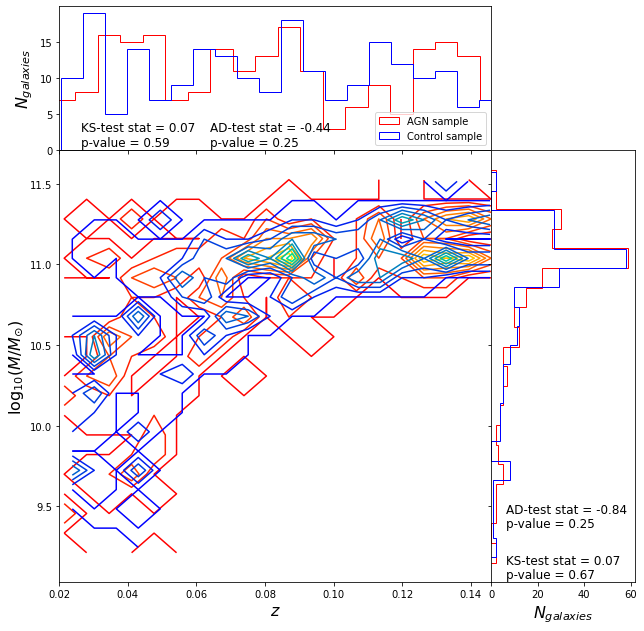

In [483]:
# Create figure
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_axes([0.1, 0.1, 0.6, 0.6])
ax2 = fig.add_axes([0.1, 0.7, 0.6, 0.2])
ax3 = fig.add_axes([0.7, 0.1, 0.2, 0.6])

z_ticks = np.arange(0.02, 0.15, 0.02)
mass_ticks = np.arange(8.5, 12, 0.5)

# Generate contour plots of mass and redshift
h_agn, x_a, y_a = np.histogram2d(obscured_agn_tb['Z'].data, np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), bins=20)
h_agn = h_agn.T
xbins_a = x_a[:-1] + (x_a[1] - x_a[0]) / 2
ybins_a = y_a[:-1] + (y_a[1] - y_a[0]) / 2
h_control, x_c, y_c = np.histogram2d(control_tb['z'].data, np.log10(control_tb['nsa_elpetro_mass'].data), bins=20)                                    
h_control = h_control.T
xbins_c = x_c[:-1] + (x_c[1] - x_c[0]) / 2
ybins_c = y_c[:-1] + (y_c[1] - y_c[0]) / 2
ax1.contour(xbins_a, ybins_a, h_agn, cmap="autumn")
ax1.contour(xbins_c, ybins_c, h_control, cmap="winter")
ax1.set_xlabel("$z$", fontsize=16)
ax1.set_xticks(z_ticks)
ax1.set_ylabel("log$_{10}(M/M_{\odot})$", fontsize=16)

# Plot redshifts
ax2.hist(obscured_agn_tb['Z'].data, bins=20, histtype="step", color="red", label="AGN sample")
ax2.hist(control_tb['z'].data, bins=20, histtype="step", color="blue", label="Control sample")
ax2.set_ylabel("$N_{galaxies}$", fontsize=16)
ax2.set_xticks(z_ticks)
ax2.sharex(ax1)
ax2.legend(loc="lower right")

# Plot logged masses
ax3.hist(np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), bins=20, histtype="step", color="red", orientation="horizontal")
ax3.hist(np.log10(control_tb['nsa_elpetro_mass'].data), bins=20, histtype="step", color="blue", orientation="horizontal")
ax3.set_xlabel("$N_{galaxies}$", fontsize=16)
ax3.sharey(ax1)

# Remove overlapping ticks and tick labels without affecting ax1
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

# Add KS-test outcomes
ax2.text(0.05, 0.2, "KS-test stat = " + "{:.2f}".format(ks_z[0]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax2.text(0.05, 0.1, "p-value = " + "{:.2f}".format(ks_z[1]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.066, "KS-test stat = " + "{:.2f}".format(ks_mass[0]), transform=ax3.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.033, "p-value = " + "{:.2f}".format(ks_mass[1]), transform=ax3.transAxes, ha='left', va='top', size=12);

# Add AD-test outcomes
ax2.text(0.35, 0.2, "AD-test stat = " + "{:.2f}".format(ad_z[0]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax2.text(0.35, 0.1, "p-value = " + "{:.2f}".format(ad_z[2]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.1833, "AD-test stat = " + "{:.2f}".format(ad_mass[0]), transform=ax3.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.15, "p-value = " + "{:.2f}".format(ad_mass[2]), transform=ax3.transAxes, ha='left', va='top', size=12);

In [566]:
# Save figure
plt.savefig("Control_Sample_Countour_Plot.jpg", dpi=400)

<Figure size 432x288 with 0 Axes>

### METHOD 2: Use np.histogramdd to construct 2D/3D bins of data

Use mock data to practise sampling technique

shape: (100, 2)


Text(0, 0.5, 'weight')

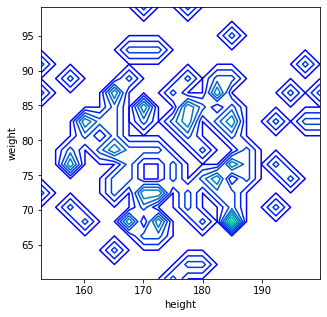

In [355]:
# Randomly generated data
height = np.random.normal(175, 10, 100)
weight = np.random.normal(80, 10, 100)
age = np.random.uniform(10, 80, 100)

data = np.vstack([height, weight, age]).T
print("shape:", np.shape(data))

# Create histogram
h, edges = np.histogramdd(data, bins=20)

# Set up bins
xbins = edges[0][:-1] + (edges[0][1] - edges[0][0]) / 2
ybins = edges[1][:-1] + (edges[1][1] - edges[1][0]) /2

# Create figure
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Plot contour plot of histogram
ax.contour(xbins, ybins, h, cmap="winter")
ax.set_xlabel("height")
ax.set_ylabel("weight")

Apply to obscured AGN data

In [564]:
# Get data and prepare for np.histogramdd
agn_z_data = obscured_agn_tb['Z'].data
agn_t_data =  Planck18.lookback_time(agn_z_data).value  # Convert z to lookback time
agn_mass_data = np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data)
# agn_gz2_data

drp_z_data = drpall_tb['z'].data
drp_t_data = Planck18.lookback_time(drp_z_data).value  # Convert z to lookback time
drp_mass_data = np.log10(drpall_tb['nsa_elpetro_mass'].data)
# control_gz2_data = 

# Use redshift
agn_data = np.vstack([agn_z_data, agn_mass_data]).T
drp_data = np.vstack([drp_z_data, drp_mass_data]).T

# Use lookback time as alternative
agn_data_alt = np.vstack([agn_t_data, agn_mass_data]).T
drp_data_alt = np.vstack([drp_t_data, drp_mass_data]).T

# Create histograms
h_agn, edges_a = np.histogramdd(agn_data, bins=20)
h_drp, edges_d = np.histogramdd(drp_data, bins=20)

h_agn_alt, edges_a_alt = np.histogramdd(agn_data_alt, bins=20)
h_drp_alt, edges_d_alt = np.histogramdd(drp_data_alt, bins=20)

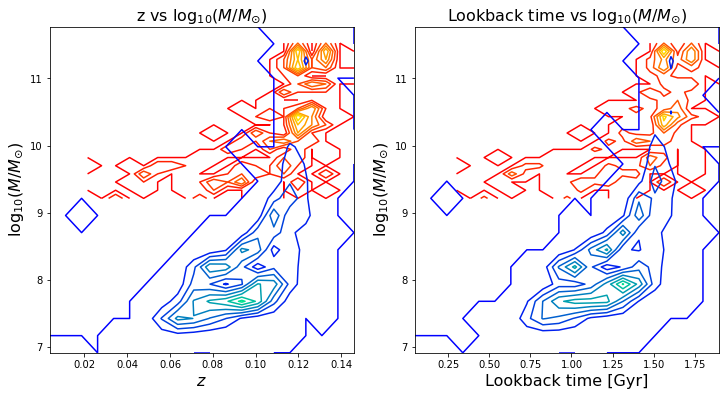

In [565]:
# Set up bins
xbins_a = edges_a[0][:-1] + (edges_a[0][1] - edges_a[0][0]) / 2
ybins_a = edges_a[1][:-1] + (edges_a[1][1] - edges_a[1][0]) / 2
xbins_d = edges_d[0][:-1] + (edges_d[0][1] - edges_d[0][0]) / 2
ybins_d = edges_d[1][:-1] + (edges_d[1][1] - edges_d[1][0]) / 2

xbins_a_alt = edges_a_alt[0][:-1] + (edges_a_alt[0][1] - edges_a_alt[0][0]) / 2
ybins_a_alt = edges_a_alt[1][:-1] + (edges_a_alt[1][1] - edges_a_alt[1][0]) / 2
xbins_d_alt = edges_d_alt[0][:-1] + (edges_d_alt[0][1] - edges_d_alt[0][0]) / 2
ybins_d_alt = edges_d_alt[1][:-1] + (edges_d_alt[1][1] - edges_d_alt[1][0]) / 2

# Create figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Plot contour plots of histograms
ax[0].contour(xbins_a, ybins_a, h_agn, cmap="autumn")
ax[0].contour(xbins_d, ybins_d, h_drp, cmap="winter")
ax[0].set_xlabel("$z$", fontsize=16)
ax[0].set_ylabel("log$_{10}(M/M_{\odot})$", fontsize=16)
ax[0].set_title("z vs log$_{10}(M/M_{\odot})$", fontsize=16);

ax[1].contour(xbins_a_alt, ybins_a_alt, h_agn_alt, cmap="autumn")
ax[1].contour(xbins_d_alt, ybins_d_alt, h_drp_alt, cmap="winter")
ax[1].set_xlabel("Lookback time [Gyr]", fontsize=16)
ax[1].set_ylabel("log$_{10}(M/M_{\odot})$", fontsize=16)
ax[1].set_title("Lookback time vs log$_{10}(M/M_{\odot})$", fontsize=16);

plt.savefig("histogramdd_mass_vs_z_and_lookback.jpg", dpi=400)

In [625]:
count_found = 0
count_not_found = 0

control_list = []

nonzero_ids = np.column_stack(np.nonzero(h_agn))
for i in range(np.count_nonzero(h_agn)):
    # Obtain coordinates in phase space
    x_id = nonzero_ids[i][0]
    y_id = nonzero_ids[i][1]
    # print("\nx, y:", x_id, y_id)
    
    # Find range of each bin to look for controls within said range
    xbins_range = (xbins_a[1] - xbins_a[0]) / 2
    ybins_range = (ybins_a[1] - ybins_a[0]) / 2
    
    # Number of AGN in each bin
    n_agn = int(h_agn[x_id, y_id])
    # print("n_agn:", n_agn)
    
    # Loop over all AGN in bin
    for j in range(n_agn):
        # Calculate values of DRPall that fall into that bin
        x_min = xbins_a[x_id] - xbins_range
        x_max = xbins_a[x_id] + xbins_range
        y_min = ybins_a[y_id] - ybins_range
        y_max = ybins_a[y_id] + ybins_range
        # print("z:", drp_z)
        # print("mass:", np.log10(drp_mass))
    
        # Search for values in drpall_tb that satisfy both binning conditions
        matches = np.where((drpall_tb['z'].data >= x_min) &
                           (drpall_tb['z'].data <= x_max) & 
                           (np.log10(drpall_tb['nsa_elpetro_mass'].data) >= y_min) &
                           (np.log10(drpall_tb['nsa_elpetro_mass'].data) <= y_max))[0]
        
        # For bins with matches
        if len(matches) > 0:
            # print("Match found!")
            count_found += 1
            
            # Select random index from bin
            ind = random.choice(matches)
            
            # Obtain necessary quantities
            plateifu = drpall_tb['plateifu'][ind]
            drp_z = drpall_tb['z'][ind]
            drp_mass = drpall_tb['nsa_elpetro_mass'][ind]
            
            # Create dictionary of data and append to main list
            data = {
                'plateifu': plateifu,
                'nsa_z': drp_z,
                'nsa_elpetro_mass': drp_mass
            }
            control_list.append(data)
            
        else:
            print("\nx, y:", x_id, y_id)
            print("No match found :(")
            count_not_found += 1
            
            # Find nearest neigbour
            # neighbour_id = lookupNearest(x0=, y0=, data=np.column_stack((drpall_tb['z'].data, np.log10(drpall_tb['nsa_elpetro_mass'].data))))
            
print("Count found:", count_found)
print("Count not found:", count_not_found)


x, y: 1 17
No match found :(

x, y: 3 17
No match found :(

x, y: 3 17
No match found :(

x, y: 4 0
No match found :(

x, y: 6 17
No match found :(

x, y: 9 17
No match found :(

x, y: 9 17
No match found :(

x, y: 11 11
No match found :(

x, y: 15 18
No match found :(

x, y: 19 19
No match found :(
Count found: 205
Count not found: 10


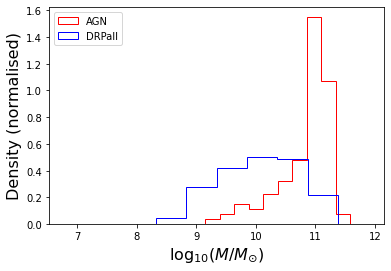

In [494]:
plt.hist(np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), histtype='step', color="red", density=True, label="AGN")
plt.hist(np.log10(drpall_tb['nsa_elpetro_mass'].data), histtype='step', color='blue', density=True, label="DRPall")
plt.xlabel("log$_{10}(M/M_{\odot})$", fontsize=16)
plt.ylabel("Density (normalised)", fontsize=16)
plt.legend();

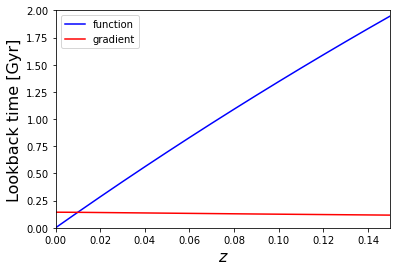

In [575]:
z = np.arange(0, 5, 0.01)
t = Planck18.lookback_time(z).value
dt = np.gradient(t)

plt.plot(z, t, color="blue", label="function")
plt.plot(z, dt, color="red", label="gradient")
plt.xlabel("$z$", fontsize=16)
plt.ylabel("Lookback time [Gyr]", fontsize=16)
plt.xlim(0, 0.15)
plt.ylim(0, 2)
plt.legend();

In [626]:
# Array of z and logged mass values (in order)
z_mass_arr = np.array([[0.02, 9.5], [0.04, 10], [0.06, 9], [0.07, 11], [0.08, 10.5]])
    
lookupNearest(0.05, 10, z_mass_arr)

1

### Method 3: Use nearest neighbour search

In [635]:
control_data_list = []

for i in range(len(dvsg_agn_tb)):
    
    # Load in data from DRPall (and GalaxyZoo2?)
    search_data = np.column_stack((drpall_tb['z'].data, np.log10(drpall_tb['nsa_elpetro_mass'].data)))
    
    # Use nearest neighbour search in parameter space to find closest value in drpall
    nearest_id = lookupNearest(dvsg_agn_tb['nsa_z'][i], np.log10(dvsg_agn_tb['nsa_elpetro_mass'][i]), search_data)
    
    # Compare AGN and control
    # print("\nAGN properties:", dvsg_agn_tb['nsa_z'][i], np.log10(dvsg_agn_tb['nsa_elpetro_mass'][i]))
    # print("Control properties:", drpall_tb['z'][nearest_id], np.log10(drpall_tb['nsa_elpetro_mass'][nearest_id]))
    
    control_data = {
        'plateifu': drpall_tb['plateifu'][nearest_id],
        'z': drpall_tb['z'][nearest_id],
        'nsa_elpetro_mass': drpall_tb['nsa_elpetro_mass'][nearest_id]
    }
    
    control_data_list.append(control_data)

# Turn into astropy table
control_tb = Table(control_data_list)
control_tb

plateifu,z,nsa_elpetro_mass
str11,float64,float64
8566-9102,0.0869569,102485000000.0
10511-9102,0.0590276,118536000000.0
10512-6103,0.0263651,17175900000.0
10518-9102,0.0286522,10864700000.0
8257-6104,0.142857,188059000000.0
9044-12703,0.117495,357951000000.0
8714-6103,0.0788339,131059000000.0
10837-12702,0.08280073,102704610000.0
9028-3704,0.050068,200605000000.0


Test control sample

In [637]:
# Compute KS values for each distribution
ks_z = ks_2samp(obscured_agn_tb['Z'].data, control_tb['z'].data)
ks_mass = ks_2samp(np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), np.log10(control_tb['nsa_elpetro_mass'].data))

# Compute AD values for each distribution
res_z = anderson_ksamp((obscured_agn_tb['Z'].data, control_tb['z'].data))
res_mass = anderson_ksamp((np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), np.log10(control_tb['nsa_elpetro_mass'].data)))

[WARNING]: p-value capped: true value larger than 0.25 (UserWarning)


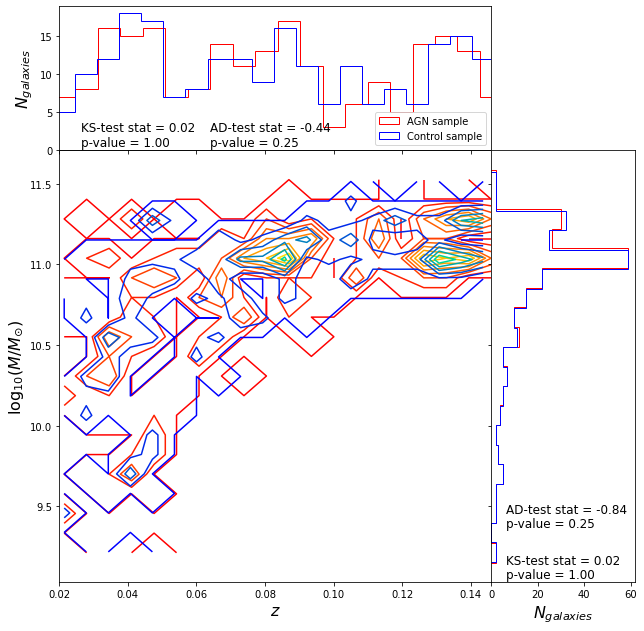

In [639]:
# Create figure
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_axes([0.1, 0.1, 0.6, 0.6])
ax2 = fig.add_axes([0.1, 0.7, 0.6, 0.2])
ax3 = fig.add_axes([0.7, 0.1, 0.2, 0.6])

z_ticks = np.arange(0.02, 0.15, 0.02)
mass_ticks = np.arange(8.5, 12, 0.5)

# Generate contour plots of mass and redshift
h_agn, x_a, y_a = np.histogram2d(obscured_agn_tb['Z'].data, np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), bins=20)
h_agn = h_agn.T
xbins_a = x_a[:-1] + (x_a[1] - x_a[0]) / 2
ybins_a = y_a[:-1] + (y_a[1] - y_a[0]) / 2
h_control, x_c, y_c = np.histogram2d(control_tb['z'].data, np.log10(control_tb['nsa_elpetro_mass'].data), bins=20)                                    
h_control = h_control.T
xbins_c = x_c[:-1] + (x_c[1] - x_c[0]) / 2
ybins_c = y_c[:-1] + (y_c[1] - y_c[0]) / 2
ax1.contour(xbins_a, ybins_a, h_agn, cmap="autumn")
ax1.contour(xbins_c, ybins_c, h_control, cmap="winter")
ax1.set_xlabel("$z$", fontsize=16)
ax1.set_xticks(z_ticks)
ax1.set_ylabel("log$_{10}(M/M_{\odot})$", fontsize=16)

# Plot redshifts
ax2.hist(obscured_agn_tb['Z'].data, bins=20, histtype="step", color="red", label="AGN sample")
ax2.hist(control_tb['z'].data, bins=20, histtype="step", color="blue", label="Control sample")
ax2.set_ylabel("$N_{galaxies}$", fontsize=16)
ax2.set_xticks(z_ticks)
ax2.sharex(ax1)
ax2.legend(loc="lower right")

# Plot logged masses
ax3.hist(np.log10(dvsg_agn_tb['nsa_elpetro_mass'].data), bins=20, histtype="step", color="red", orientation="horizontal")
ax3.hist(np.log10(control_tb['nsa_elpetro_mass'].data), bins=20, histtype="step", color="blue", orientation="horizontal")
ax3.set_xlabel("$N_{galaxies}$", fontsize=16)
ax3.sharey(ax1)

# Remove overlapping ticks and tick labels without affecting ax1
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

# Add KS-test outcomes
ax2.text(0.05, 0.2, "KS-test stat = " + "{:.2f}".format(ks_z[0]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax2.text(0.05, 0.1, "p-value = " + "{:.2f}".format(ks_z[1]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.066, "KS-test stat = " + "{:.2f}".format(ks_mass[0]), transform=ax3.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.033, "p-value = " + "{:.2f}".format(ks_mass[1]), transform=ax3.transAxes, ha='left', va='top', size=12);

# Add AD-test outcomes
ax2.text(0.35, 0.2, "AD-test stat = " + "{:.2f}".format(ad_z[0]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax2.text(0.35, 0.1, "p-value = " + "{:.2f}".format(ad_z[2]), transform=ax2.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.1833, "AD-test stat = " + "{:.2f}".format(ad_mass[0]), transform=ax3.transAxes, ha='left', va='top', size=12)
ax3.text(0.1, 0.15, "p-value = " + "{:.2f}".format(ad_mass[2]), transform=ax3.transAxes, ha='left', va='top', size=12);

plt.savefig("Control_Sample_Nearest_Neighbour.jpg", dpi=400)